## We first loaded the intrinsic matrices and distortion coefficients calculated from our code in calibration.py

In [1]:
import numpy as np

with np.load('intrinsics/aryan_calibration_data.npz') as calibration_data:
    callibration1 = calibration_data['mtx']
    distortion1 = calibration_data['dist'][0]

print("left camera:")
print(callibration1)
print(distortion1)

with np.load('intrinsics/shreyansh_calibration_data.npz') as calibration_data:
    callibration2 = calibration_data['mtx']
    distortion2 = calibration_data['dist'][0]

print("\nright camera:")
print(callibration2)
print(distortion2)

left camera:
[[3.04178524e+03 0.00000000e+00 1.58771586e+03]
 [0.00000000e+00 3.03739654e+03 1.51810990e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[ 3.94833030e-02 -4.67790713e-01  1.20152321e-03  5.50505183e-04
  1.81732987e+00]

right camera:
[[3.35335776e+03 0.00000000e+00 1.14263851e+03]
 [0.00000000e+00 3.36079956e+03 1.98509186e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[ 4.28376981e-01 -3.29428514e+00 -1.12620290e-02 -4.65517348e-04
  7.82166843e+00]


## 2. Next we estimate the extrinsic parameters between the two cameras using keypoint correspondences of the stereo image captures

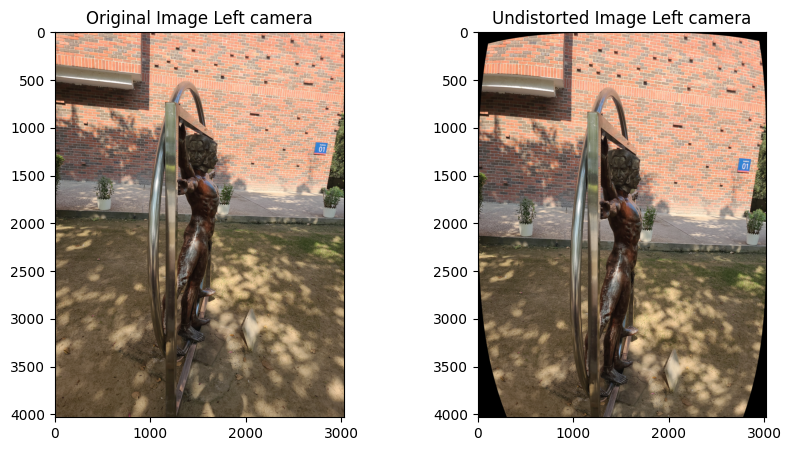

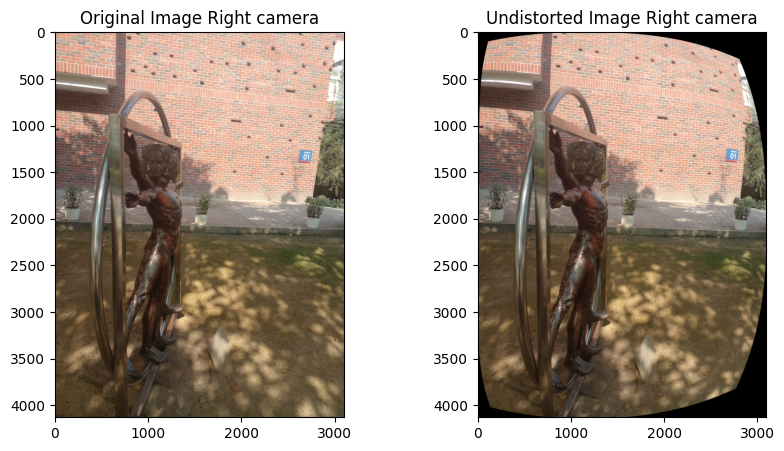

Rotation matrix:
[[ 0.99942193 -0.02395762 -0.02412151]
 [ 0.02301932  0.99899525 -0.03845271]
 [ 0.02501851  0.03787522  0.99896924]]
Translation vector:
[[-0.98332926]
 [ 0.17217049]
 [-0.05848839]]


In [2]:
# use the intrinsics and distortion coefficients to undistort the images, and get the extrinsics

import cv2
import matplotlib.pyplot as plt

img1 = cv2.imread('datasets/Aryan_maingate_statue/1.jpg')
img2 = cv2.imread('datasets/shreyansh_maingate_statue/1.jpg')

K1 = callibration1
D1 = distortion1
K2 = callibration2
D2 = distortion2

# 1. first we need to undistort the images
h1, w1 = img1.shape[:2]
newK1, roi1 = cv2.getOptimalNewCameraMatrix(K1, D1, (w1, h1), 1, (w1, h1))

h2, w2 = img2.shape[:2]
newK2, roi2 = cv2.getOptimalNewCameraMatrix(K2, D2, (w2, h2), 1, (w2, h2))


img1_undistorted = cv2.undistort(img1, K1, D1, None, newK1)
img2_undistorted = cv2.undistort(img2, K2, D2, None, newK2)

# plot original and undistorted images
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Original Image Left camera')
plt.subplot(122)
plt.imshow(cv2.cvtColor(img1_undistorted, cv2.COLOR_BGR2RGB))
plt.title('Undistorted Image Left camera')
plt.show()
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Original Image Right camera')
plt.subplot(122)
plt.imshow(cv2.cvtColor(img2_undistorted, cv2.COLOR_BGR2RGB))
plt.title('Undistorted Image Right camera')
plt.show()

# 2. then we perform feature detection and get matching keypoints

img1_undistorted_copy = img1_undistorted.copy()
img2_undistorted_copy = img2_undistorted.copy()

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1_undistorted, None)
kp2, des2 = sift.detectAndCompute(img2_undistorted, None)
# match features using FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)
# filter out the bad matches using lowe's ratio test
good_matches = []
good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance] 
# get the matched keypoints
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# 3. next we use the matched keypoints to get the fundamental matrix
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS)
# we select only inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

# 4. we use the fundamental matrix to get the essential matrix
E = np.dot(np.dot(K2.T, F), K1)
# we decompose the essential matrix to get the rotation and translation
_, R, t, mask = cv2.recoverPose(E, pts1, pts2, K1)

print("Rotation matrix:")
print(R)
print("Translation vector:")
print(t)

## 3. We use homography to verify that our rotation and translation matrices are correct

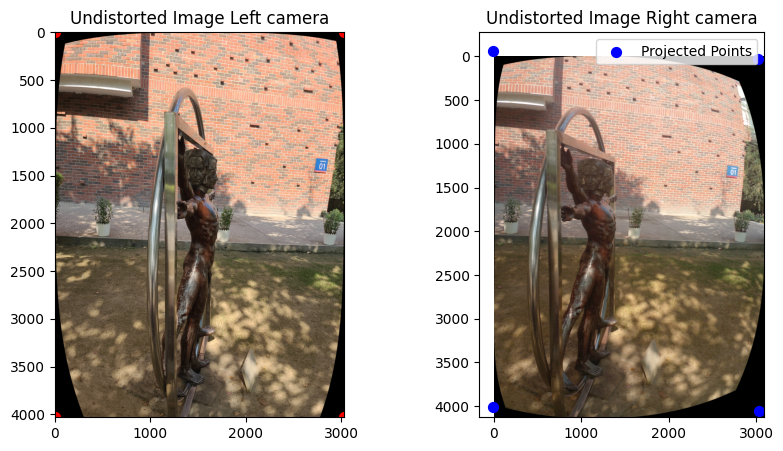

In [ ]:
import matplotlib.pyplot as plt

P1 = np.dot(newK1, np.hstack((np.eye(3), np.zeros((3, 1)))))  # Left camera: P1 = K1 * [I|0]
P2 = np.dot(newK2, np.hstack((R, t)))  # Right camera: P2 = K2 * [R|t]

h, w = img1_undistorted.shape[:2]
points1 = np.array([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]], dtype=np.float32).T

points1_homogeneous = np.vstack((points1, np.ones((1, points1.shape[1]))))

points_3D_homogeneous = cv2.triangulatePoints(P1, P2, points1[:2], points1[:2])

points_3D = points_3D_homogeneous[:3] / points_3D_homogeneous[3]

projected_points_homogeneous = np.dot(P2, np.vstack((points_3D, np.ones((1, points_3D.shape[1])))))
projected_points = projected_points_homogeneous[:2] / projected_points_homogeneous[2]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(cv2.cvtColor(img1_undistorted, cv2.COLOR_BGR2RGB))
axs[0].scatter(points1[0], points1[1], c='red', s=50, label='Original Points')
axs[0].set_title('Undistorted Image Left camera')

axs[1].imshow(cv2.cvtColor(img2_undistorted, cv2.COLOR_BGR2RGB))
axs[1].scatter(projected_points[0], projected_points[1], c='blue', s=50, label='Projected Points')
axs[1].set_title('Undistorted Image Right camera')

plt.legend()
plt.show()


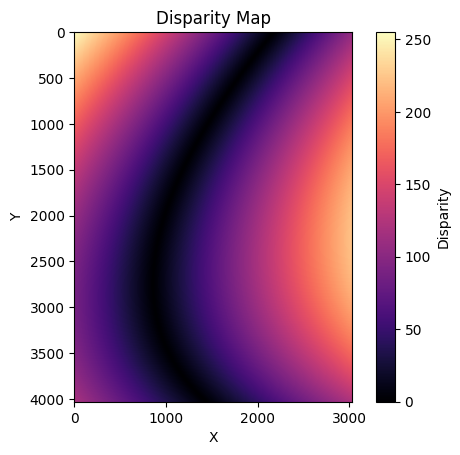

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Generate a dense grid of points on the first image (covering all pixels)
x_range = np.linspace(0, w - 1, w)
y_range = np.linspace(0, h - 1, h)
x_grid, y_grid = np.meshgrid(x_range, y_range)
points1_grid = np.vstack((x_grid.ravel(), y_grid.ravel()))

# Convert the grid to homogeneous coordinates for triangulation
points1_homogeneous = np.vstack((points1_grid, np.ones((1, points1_grid.shape[1]))))

# Project the dense grid onto the right camera's image plane using the known R and t
# These projections assume points lie on a plane at Z = 1 (epipolar geometry simplification)
points1_homogeneous_camera = np.linalg.inv(newK1) @ points1_homogeneous  # Normalize points
points1_homogeneous_camera[2, :] = 1  # Assume a plane at Z = 1

# Transform to the right camera frame using the rotation and translation
points2_homogeneous_camera = R @ points1_homogeneous_camera + t

# Reproject points from the right camera frame back to pixel coordinates
points2_projected = newK2 @ points2_homogeneous_camera
points2_projected /= points2_projected[2, :]  # Normalize to pixel coordinates

# Compute disparity as the difference in x-coordinates
disparity = points1_homogeneous[0, :] - points2_projected[0, :]

# Reshape the disparity map back to the image dimensions
disparity_map = disparity.reshape(h, w)

# Normalize disparity for visualization (optional)
disparity_map_normalized = cv2.normalize(disparity_map, None, 0, 255, cv2.NORM_MINMAX)

# Display the disparity map
plt.imshow(disparity_map_normalized, cmap='magma')
plt.colorbar(label='Disparity')
plt.title('Disparity Map')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
